In [16]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from math import log10,sqrt
     

In [17]:
train_data=sorted(os.listdir('/kaggle/input/chest-xrays-radiopaedia/images/images'))
noise_data=sorted(os.listdir('/kaggle/input/chest-noisy/chest noisy-20230306T183108Z-001/chest noisy'))

In [18]:
train_data_dir='/kaggle/input/chest-xrays-radiopaedia/images/images'
noise_data_dir='/kaggle/input/chest-noisy/chest noisy-20230306T183108Z-001/chest noisy'

In [19]:
from tqdm.notebook import tqdm
train_image = []
for file in tqdm(sorted(os.listdir(train_data_dir))):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(train_data_dir + '/' + file, target_size=(256,256))
    image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
    train_image.append(image)

train_image = np.array(train_image)

  0%|          | 0/3662 [00:00<?, ?it/s]

In [20]:
print(train_image.shape)

(3549, 256, 256, 3)


In [21]:
# #Subplotting images
# def plot_img(dataset):
#   f,ax=plt.subplots(1,5)
#   f.set_size_inches(40,20)
#   for i in range(5,10):
#     ax[i-5].imshow(dataset[i], cmap='gray')
#   plt.show()

In [22]:
# #Adding gaussian noise with 0.05 factor
# def add_noise(image):
#   row,col,ch=image.shape
#   mean=0
#   sigma=1
#   gauss=np.random.normal(mean,sigma,(row,col,ch))
#   gauss=gauss.reshape(row,col,ch)
#   noisy=image+gauss*0.05
#   return noisy

In [23]:
noised_image = []
for file in tqdm(sorted(os.listdir(noise_data_dir))):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(noise_data_dir + '/' + file, target_size=(256,256))
    image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
    noised_image.append(image)

noised_image = np.array(noised_image)

  0%|          | 0/3662 [00:00<?, ?it/s]

In [24]:
#Subplotting images
def plot_img(dataset):
  f,ax=plt.subplots(1,5)
  f.set_size_inches(40,20)
  for i in range(5,10):
    ax[i-5].imshow(dataset[i], cmap='gray')
  plt.show()

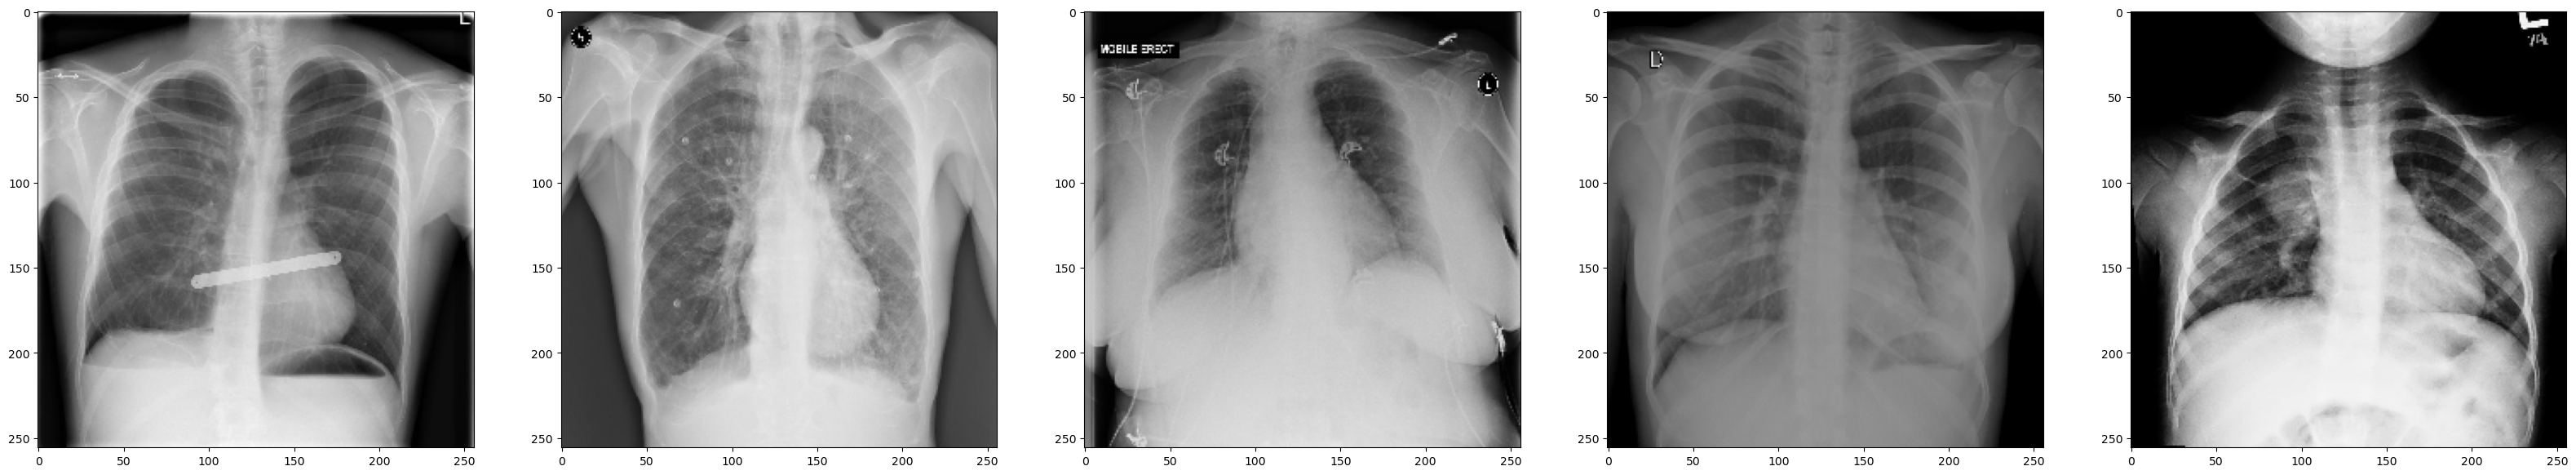

In [25]:
plot_img(train_image)

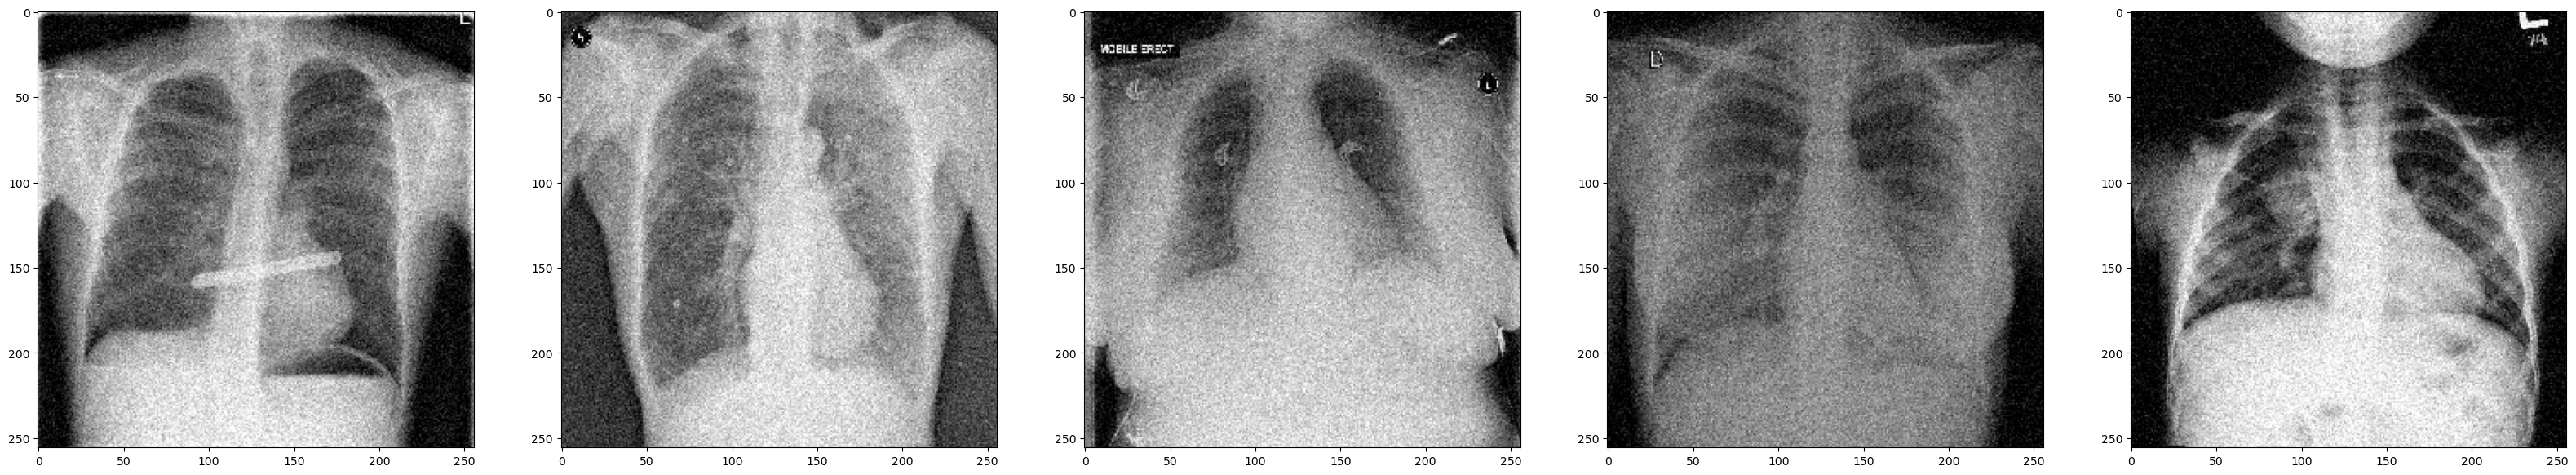

In [26]:
plot_img(noised_image)

In [27]:
xnoised=noised_image[:400]
xtest=noised_image[400:]
     

In [28]:
def autoencoder():
  input_img=Input(shape=(256,256,3),name='image_input')
  #enoder 
  x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
  x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
  x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv2')(x)
  x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
   
  #decoder
  x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv3')(x)
  x = UpSampling2D((2,2), name='upsample1')(x)
  x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv4')(x)
  x = UpSampling2D((2,2), name='upsample2')(x)
  x = Conv2D(3, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
   
  #model
  autoencoder = Model(inputs=input_img, outputs=x)
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
  return autoencoder


In [29]:
model= autoencoder()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 256, 256, 32)      896       
                                                                 
 pool1 (MaxPooling2D)        (None, 128, 128, 32)      0         
                                                                 
 Conv2 (Conv2D)              (None, 128, 128, 32)      9248      
                                                                 
 pool2 (MaxPooling2D)        (None, 64, 64, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 64, 64, 32)        9248      
                                                                 
 upsample1 (UpSampling2D)    (None, 128, 128, 32)      0   

In [30]:
with tf.device('/device:GPU:0'):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    model.fit(xnoised, xnoised, epochs=5, batch_size=10, validation_data=(xtest, xtest), callbacks=[early_stopping])

Epoch 1/5
40/40 [==============================] - 173s 4s/step - loss: 0.6028 - val_loss: 0.5560
Epoch 2/5
40/40 [==============================] - 168s 4s/step - loss: 0.5516 - val_loss: 0.5496
Epoch 3/5
40/40 [==============================] - 167s 4s/step - loss: 0.5481 - val_loss: 0.5475
Epoch 4/5
40/40 [==============================] - 166s 4s/step - loss: 0.5464 - val_loss: 0.5476
Epoch 5/5
40/40 [==============================] - 181s 5s/step - loss: 0.5459 - val_loss: 0.5454


In [31]:
xtrain= train_image[100:]

1/1 [==============================] - 1s 681ms/step


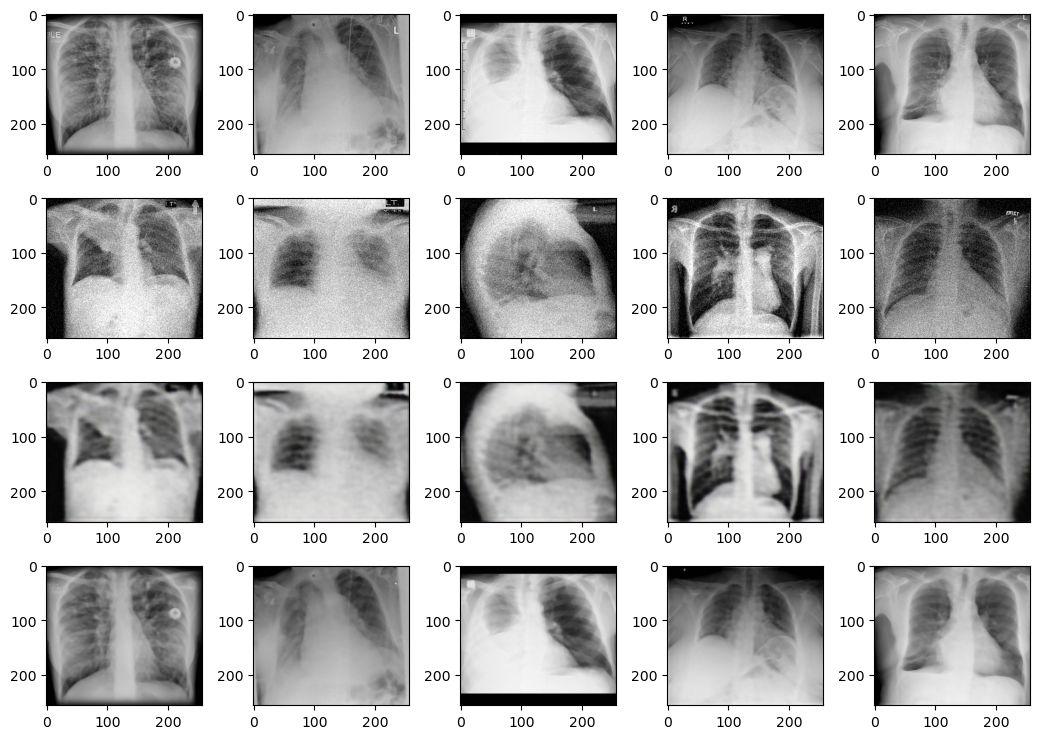

In [32]:
pred= model.predict(xtest[:5])
def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(4, 5)
    f.set_size_inches(10.5,7.5)
    for i in range(5):
        ax[0][i].imshow(np.reshape(xtrain[i], (256,256,3)), aspect='auto', cmap='gray')
        ax[1][i].imshow(np.reshape(y_true[i], (256,256,3)), aspect='auto', cmap='gray')
        ax[2][i].imshow(np.reshape(y_pred[i], (256,256,3)), aspect='auto', cmap='gray')
        ax[3][i].imshow(cv2.medianBlur(xtrain[i], (5)), aspect='auto', cmap='gray')
    plt.tight_layout()
plot_predictions(xtest[:5], pred[:5])

In [37]:
# median_blur = cv2.medianBlur(xtrain[0], (5))
# gaussian_blur=cv2.GaussianBlur(xtrain[0],(5,5),0)
# average_blur=cv2.blur(xtrain[0],(5,5))
# bilateral_filter=cv2.bilateralFilter(xtrain[0],9,75,75)
#f,ax=plt.subplots(1,2)
#f.set_size_inches(40,20)
#ax[0].imshow(pred[0].reshape(256,256,3), cmap='gray')
#ax[0].set_title('Autoencoder Image')
# ax[1].imshow(median_blur,cmap='gray')
# ax[1].set_title('Median Filter')
# ax[2].imshow(gaussian_blur,cmap='gray')
# ax[2].set_title('Gaussian Filter')
# ax[3].imshow(average_blur,cmap='gray')
# ax[3].set_title('Average Filter')
# ax[4].imshow(bilateral_filter,cmap='gray')
# ax[4].set_title('Bilateral Filter')

In [38]:
def PSNR(original, denoised): 
    mse = np.mean((original - denoised) ** 2) 
    if(mse == 0): 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

  
#value1 = PSNR(xtest[0], median_blur)
value2 = PSNR(xtest[0], pred[0])
#value3 = PSNR(xtest[0], gaussian_blur)
#value4 = PSNR(xtest[0], average_blur)
#value5 = PSNR(xtest[0], bilateral_filter)

#print("PSNR values")
print(f"Autoencoder Image : {value2} dB")
#print(f"Median Filter Image : {value1} dB")
#print(f"Gaussian Filter Image : {value3} dB")
#print(f"Average Filter Image : {value4} dB")
#print(f"Bilateral Filter Image : {value5} dB")

Autoencoder Image : 69.82898390980381 dB


In [39]:
def PSNR(original, denoised): 
    mse = np.mean((original - denoised) ** 2) 
    if(mse == 0): 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 
value2 = PSNR(xtrain[0], pred[0])
value1 = PSNR(xtest[0],pred[0])
print(f"Autoencoder Image : {value2} dB")
print(f"Autoencoderless Image : {value1} dB")

Autoencoder Image : 59.74653633945224 dB
Autoencoderless Image : 69.82898390980381 dB


In [36]:
from tensorflow.keras.models import load_model
model.save('/kaggle/working/code.h5')